In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_0_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(317441, 828)
(317441, 1)
validation
(36648, 828)
(36648, 1)
test
(43097, 828)
(43097, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/32 [..............................] - ETA: 46s - loss: 0.0521 - STD: 8.9791e-05 - MAE: 0.2198

 4/32 [==>...........................] - ETA: 0s - loss: 0.0300 - STD: 2.4504e-04 - MAE: 0.1291 

 5/32 [===>..........................] - ETA: 0s - loss: 0.0300 - STD: 2.3211e-04 - MAE: 0.1291

 6/32 [====>.........................] - ETA: 1s - loss: 0.0297 - STD: 2.2169e-04 - MAE: 0.1275

 7/32 [=====>........................] - ETA: 1s - loss: 0.0286 - STD: 2.1675e-04 - MAE: 0.1233

 8/32 [======>.......................] - ETA: 1s - loss: 0.0273 - STD: 2.1855e-04 - MAE: 0.1170

 9/32 [=======>......................] - ETA: 1s - loss: 0.0259 - STD: 2.2565e-04 - MAE: 0.1110

10/32 [========>.....................] - ETA: 1s - loss: 0.0247 - STD: 2.3597e-04 - MAE: 0.1080

11/32 [=========>....................] - ETA: 1s - loss: 0.0239 - STD: 2.4769e-04 - MAE: 0.1075

12/32 [==========>...................] - ETA: 1s - loss: 0.0234 - STD: 2.5928e-04 - MAE: 0.1084

13/32 [===========>..................] - ETA: 2s - loss: 0.0232 - STD: 2.7075e-04 - MAE: 0.1096

16/32 [==============>...............] - ETA: 1s - loss: 0.0218 - STD: 3.0205e-04 - MAE: 0.1086

18/32 [===============>..............] - ETA: 1s - loss: 0.0209 - STD: 3.1813e-04 - MAE: 0.1045

19/32 [================>.............] - ETA: 1s - loss: 0.0206 - STD: 3.2469e-04 - MAE: 0.1023

20/32 [=================>............] - ETA: 1s - loss: 0.0204 - STD: 3.3095e-04 - MAE: 0.1003

21/32 [==================>...........] - ETA: 0s - loss: 0.0201 - STD: 3.3738e-04 - MAE: 0.0986

22/32 [===================>..........] - ETA: 0s - loss: 0.0200 - STD: 3.4410e-04 - MAE: 0.0970

23/32 [====================>.........] - ETA: 0s - loss: 0.0198 - STD: 3.5152e-04 - MAE: 0.0957

24/32 [=====================>........] - ETA: 0s - loss: 0.0196 - STD: 3.5969e-04 - MAE: 0.0943

25/32 [======================>.......] - ETA: 0s - loss: 0.0194 - STD: 3.6853e-04 - MAE: 0.0932

26/32 [=======================>......] - ETA: 0s - loss: 0.0192 - STD: 3.7831e-04 - MAE: 0.0923

27/32 [========================>.....] - ETA: 0s - loss: 0.0190 - STD: 3.8862e-04 - MAE: 0.0918

28/32 [=========================>....] - ETA: 0s - loss: 0.0188 - STD: 3.9982e-04 - MAE: 0.0915

29/32 [==========================>...] - ETA: 0s - loss: 0.0187 - STD: 4.1133e-04 - MAE: 0.0915

30/32 [===========================>..] - ETA: 0s - loss: 0.0185 - STD: 4.2334e-04 - MAE: 0.0915

31/32 [============================>.] - ETA: 0s - loss: 0.0184 - STD: 4.3564e-04 - MAE: 0.0916

32/32 [==============================] - ETA: 0s - loss: 0.0183 - STD: 4.4790e-04 - MAE: 0.0915

32/32 [==============================] - 5s 102ms/step - loss: 0.0183 - STD: 4.4790e-04 - MAE: 0.0915 - val_loss: 0.0189 - val_STD: 8.0814e-04 - val_MAE: 0.0959


Epoch 2/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0146 - STD: 8.5360e-04 - MAE: 0.0857

 2/32 [>.............................] - ETA: 1s - loss: 0.0141 - STD: 8.6314e-04 - MAE: 0.0820

 3/32 [=>............................] - ETA: 1s - loss: 0.0138 - STD: 8.7341e-04 - MAE: 0.0788

 4/32 [==>...........................] - ETA: 1s - loss: 0.0139 - STD: 8.8769e-04 - MAE: 0.0766

 5/32 [===>..........................] - ETA: 1s - loss: 0.0138 - STD: 9.0210e-04 - MAE: 0.0744

 6/32 [====>.........................] - ETA: 1s - loss: 0.0138 - STD: 9.1670e-04 - MAE: 0.0729

 7/32 [=====>........................] - ETA: 1s - loss: 0.0139 - STD: 9.3388e-04 - MAE: 0.0718

 8/32 [======>.......................] - ETA: 1s - loss: 0.0140 - STD: 9.5438e-04 - MAE: 0.0712

 9/32 [=======>......................] - ETA: 1s - loss: 0.0139 - STD: 9.7634e-04 - MAE: 0.0707

11/32 [=========>....................] - ETA: 1s - loss: 0.0139 - STD: 0.0010 - MAE: 0.0707    

12/32 [==========>...................] - ETA: 1s - loss: 0.0139 - STD: 0.0011 - MAE: 0.0711

13/32 [===========>..................] - ETA: 1s - loss: 0.0139 - STD: 0.0011 - MAE: 0.0716

14/32 [============>.................] - ETA: 1s - loss: 0.0138 - STD: 0.0011 - MAE: 0.0722

15/32 [=============>................] - ETA: 1s - loss: 0.0139 - STD: 0.0012 - MAE: 0.0729

16/32 [==============>...............] - ETA: 0s - loss: 0.0139 - STD: 0.0012 - MAE: 0.0734

17/32 [==============>...............] - ETA: 0s - loss: 0.0138 - STD: 0.0012 - MAE: 0.0737

18/32 [===============>..............] - ETA: 0s - loss: 0.0138 - STD: 0.0013 - MAE: 0.0740

19/32 [================>.............] - ETA: 0s - loss: 0.0139 - STD: 0.0013 - MAE: 0.0741

20/32 [=================>............] - ETA: 0s - loss: 0.0139 - STD: 0.0014 - MAE: 0.0741

21/32 [==================>...........] - ETA: 0s - loss: 0.0138 - STD: 0.0014 - MAE: 0.0740

22/32 [===================>..........] - ETA: 0s - loss: 0.0138 - STD: 0.0014 - MAE: 0.0737

23/32 [====================>.........] - ETA: 0s - loss: 0.0138 - STD: 0.0015 - MAE: 0.0735

24/32 [=====================>........] - ETA: 0s - loss: 0.0138 - STD: 0.0016 - MAE: 0.0733

25/32 [======================>.......] - ETA: 0s - loss: 0.0138 - STD: 0.0016 - MAE: 0.0731

26/32 [=======================>......] - ETA: 0s - loss: 0.0137 - STD: 0.0017 - MAE: 0.0730

27/32 [========================>.....] - ETA: 0s - loss: 0.0137 - STD: 0.0017 - MAE: 0.0730

28/32 [=========================>....] - ETA: 0s - loss: 0.0138 - STD: 0.0018 - MAE: 0.0731

29/32 [==========================>...] - ETA: 0s - loss: 0.0137 - STD: 0.0019 - MAE: 0.0732

30/32 [===========================>..] - ETA: 0s - loss: 0.0137 - STD: 0.0020 - MAE: 0.0733

31/32 [============================>.] - ETA: 0s - loss: 0.0137 - STD: 0.0021 - MAE: 0.0734

32/32 [==============================] - ETA: 0s - loss: 0.0137 - STD: 0.0021 - MAE: 0.0734

32/32 [==============================] - 2s 64ms/step - loss: 0.0137 - STD: 0.0021 - MAE: 0.0734 - val_loss: 0.0179 - val_STD: 0.0052 - val_MAE: 0.0861


Epoch 3/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0125 - STD: 0.0054 - MAE: 0.0726

 2/32 [>.............................] - ETA: 1s - loss: 0.0130 - STD: 0.0056 - MAE: 0.0732

 3/32 [=>............................] - ETA: 1s - loss: 0.0130 - STD: 0.0059 - MAE: 0.0725

 4/32 [==>...........................] - ETA: 1s - loss: 0.0131 - STD: 0.0062 - MAE: 0.0722

 5/32 [===>..........................] - ETA: 1s - loss: 0.0130 - STD: 0.0064 - MAE: 0.0714

 6/32 [====>.........................] - ETA: 1s - loss: 0.0130 - STD: 0.0067 - MAE: 0.0711

 7/32 [=====>........................] - ETA: 1s - loss: 0.0130 - STD: 0.0071 - MAE: 0.0709

 8/32 [======>.......................] - ETA: 1s - loss: 0.0129 - STD: 0.0074 - MAE: 0.0706

 9/32 [=======>......................] - ETA: 1s - loss: 0.0128 - STD: 0.0078 - MAE: 0.0706

10/32 [========>.....................] - ETA: 1s - loss: 0.0127 - STD: 0.0083 - MAE: 0.0706

11/32 [=========>....................] - ETA: 1s - loss: 0.0127 - STD: 0.0088 - MAE: 0.0706

12/32 [==========>...................] - ETA: 1s - loss: 0.0126 - STD: 0.0093 - MAE: 0.0707

13/32 [===========>..................] - ETA: 1s - loss: 0.0126 - STD: 0.0098 - MAE: 0.0705

14/32 [============>.................] - ETA: 1s - loss: 0.0124 - STD: 0.0104 - MAE: 0.0702

15/32 [=============>................] - ETA: 1s - loss: 0.0123 - STD: 0.0110 - MAE: 0.0698

16/32 [==============>...............] - ETA: 0s - loss: 0.0123 - STD: 0.0117 - MAE: 0.0694

17/32 [==============>...............] - ETA: 0s - loss: 0.0122 - STD: 0.0125 - MAE: 0.0690

18/32 [===============>..............] - ETA: 0s - loss: 0.0120 - STD: 0.0133 - MAE: 0.0685

19/32 [================>.............] - ETA: 0s - loss: 0.0119 - STD: 0.0142 - MAE: 0.0682

20/32 [=================>............] - ETA: 0s - loss: 0.0118 - STD: 0.0152 - MAE: 0.0678

21/32 [==================>...........] - ETA: 0s - loss: 0.0117 - STD: 0.0162 - MAE: 0.0675

22/32 [===================>..........] - ETA: 0s - loss: 0.0116 - STD: 0.0173 - MAE: 0.0670

23/32 [====================>.........] - ETA: 0s - loss: 0.0114 - STD: 0.0185 - MAE: 0.0666

24/32 [=====================>........] - ETA: 0s - loss: 0.0113 - STD: 0.0198 - MAE: 0.0661

26/32 [=======================>......] - ETA: 0s - loss: 0.0111 - STD: 0.0225 - MAE: 0.0651

27/32 [========================>.....] - ETA: 0s - loss: 0.0109 - STD: 0.0239 - MAE: 0.0646

28/32 [=========================>....] - ETA: 0s - loss: 0.0108 - STD: 0.0253 - MAE: 0.0641

29/32 [==========================>...] - ETA: 0s - loss: 0.0106 - STD: 0.0268 - MAE: 0.0636

30/32 [===========================>..] - ETA: 0s - loss: 0.0104 - STD: 0.0283 - MAE: 0.0631

31/32 [============================>.] - ETA: 0s - loss: 0.0103 - STD: 0.0298 - MAE: 0.0626

32/32 [==============================] - ETA: 0s - loss: 0.0101 - STD: 0.0313 - MAE: 0.0621

32/32 [==============================] - 2s 64ms/step - loss: 0.0101 - STD: 0.0313 - MAE: 0.0621 - val_loss: 0.0071 - val_STD: 0.0705 - val_MAE: 0.0513


Epoch 4/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0054 - STD: 0.0810 - MAE: 0.0467

 2/32 [>.............................] - ETA: 1s - loss: 0.0052 - STD: 0.0818 - MAE: 0.0459

 3/32 [=>............................] - ETA: 1s - loss: 0.0051 - STD: 0.0827 - MAE: 0.0454

 4/32 [==>...........................] - ETA: 1s - loss: 0.0050 - STD: 0.0833 - MAE: 0.0450

 5/32 [===>..........................] - ETA: 1s - loss: 0.0050 - STD: 0.0840 - MAE: 0.0448

 6/32 [====>.........................] - ETA: 1s - loss: 0.0049 - STD: 0.0849 - MAE: 0.0445

 7/32 [=====>........................] - ETA: 1s - loss: 0.0048 - STD: 0.0856 - MAE: 0.0440

 8/32 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0867 - MAE: 0.0438

10/32 [========>.....................] - ETA: 1s - loss: 0.0047 - STD: 0.0876 - MAE: 0.0432

11/32 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0885 - MAE: 0.0429

12/32 [==========>...................] - ETA: 1s - loss: 0.0045 - STD: 0.0892 - MAE: 0.0426

13/32 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0901 - MAE: 0.0424

14/32 [============>.................] - ETA: 1s - loss: 0.0044 - STD: 0.0910 - MAE: 0.0422

15/32 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0915 - MAE: 0.0419

16/32 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0916 - MAE: 0.0417

17/32 [==============>...............] - ETA: 0s - loss: 0.0043 - STD: 0.0922 - MAE: 0.0415

18/32 [===============>..............] - ETA: 0s - loss: 0.0043 - STD: 0.0930 - MAE: 0.0414

19/32 [================>.............] - ETA: 0s - loss: 0.0043 - STD: 0.0934 - MAE: 0.0413

20/32 [=================>............] - ETA: 0s - loss: 0.0042 - STD: 0.0936 - MAE: 0.0411

21/32 [==================>...........] - ETA: 0s - loss: 0.0042 - STD: 0.0938 - MAE: 0.0409

22/32 [===================>..........] - ETA: 0s - loss: 0.0042 - STD: 0.0941 - MAE: 0.0407

23/32 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.0946 - MAE: 0.0406

24/32 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0950 - MAE: 0.0405

25/32 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0953 - MAE: 0.0403

26/32 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0956 - MAE: 0.0402

27/32 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0959 - MAE: 0.0401

28/32 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0963 - MAE: 0.0399

29/32 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0965 - MAE: 0.0398

30/32 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0967 - MAE: 0.0396

31/32 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0968 - MAE: 0.0395

32/32 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0971 - MAE: 0.0394

32/32 [==============================] - 2s 64ms/step - loss: 0.0039 - STD: 0.0971 - MAE: 0.0394 - val_loss: 0.0035 - val_STD: 0.0944 - val_MAE: 0.0385


Epoch 5/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0031 - STD: 0.1067 - MAE: 0.0361

 2/32 [>.............................] - ETA: 1s - loss: 0.0030 - STD: 0.1042 - MAE: 0.0355

 3/32 [=>............................] - ETA: 1s - loss: 0.0031 - STD: 0.1030 - MAE: 0.0356

 4/32 [==>...........................] - ETA: 1s - loss: 0.0031 - STD: 0.1037 - MAE: 0.0356

 5/32 [===>..........................] - ETA: 1s - loss: 0.0030 - STD: 0.1045 - MAE: 0.0356

 6/32 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.1045 - MAE: 0.0356

 7/32 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.1040 - MAE: 0.0355

 8/32 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.1038 - MAE: 0.0355

 9/32 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.1041 - MAE: 0.0355

10/32 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.1046 - MAE: 0.0354

11/32 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.1049 - MAE: 0.0354

12/32 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.1047 - MAE: 0.0353

14/32 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.1050 - MAE: 0.0352

15/32 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.1051 - MAE: 0.0351

16/32 [==============>...............] - ETA: 0s - loss: 0.0029 - STD: 0.1051 - MAE: 0.0350

17/32 [==============>...............] - ETA: 0s - loss: 0.0029 - STD: 0.1048 - MAE: 0.0349

18/32 [===============>..............] - ETA: 0s - loss: 0.0029 - STD: 0.1048 - MAE: 0.0349

19/32 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.1050 - MAE: 0.0349

20/32 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.1053 - MAE: 0.0348

21/32 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.1053 - MAE: 0.0348

22/32 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.1051 - MAE: 0.0347

23/32 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.1051 - MAE: 0.0346

24/32 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.1052 - MAE: 0.0346

25/32 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.1053 - MAE: 0.0345

26/32 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.1053 - MAE: 0.0345

27/32 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.1054 - MAE: 0.0344

28/32 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1055 - MAE: 0.0343

29/32 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.1055 - MAE: 0.0343

30/32 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.1055 - MAE: 0.0342

31/32 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1055 - MAE: 0.0342

32/32 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1055 - MAE: 0.0341

32/32 [==============================] - 2s 65ms/step - loss: 0.0027 - STD: 0.1055 - MAE: 0.0341 - val_loss: 0.0025 - val_STD: 0.0970 - val_MAE: 0.0342


Epoch 6/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0025 - STD: 0.1033 - MAE: 0.0328

 2/32 [>.............................] - ETA: 1s - loss: 0.0024 - STD: 0.1042 - MAE: 0.0326

 3/32 [=>............................] - ETA: 1s - loss: 0.0024 - STD: 0.1049 - MAE: 0.0325

 4/32 [==>...........................] - ETA: 1s - loss: 0.0024 - STD: 0.1047 - MAE: 0.0325

 5/32 [===>..........................] - ETA: 1s - loss: 0.0024 - STD: 0.1047 - MAE: 0.0325

 6/32 [====>.........................] - ETA: 1s - loss: 0.0024 - STD: 0.1055 - MAE: 0.0326

 7/32 [=====>........................] - ETA: 1s - loss: 0.0024 - STD: 0.1055 - MAE: 0.0325

 8/32 [======>.......................] - ETA: 1s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0325

 9/32 [=======>......................] - ETA: 1s - loss: 0.0024 - STD: 0.1065 - MAE: 0.0325

10/32 [========>.....................] - ETA: 1s - loss: 0.0024 - STD: 0.1064 - MAE: 0.0325

11/32 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.1061 - MAE: 0.0324

12/32 [==========>...................] - ETA: 1s - loss: 0.0024 - STD: 0.1064 - MAE: 0.0324

13/32 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.1064 - MAE: 0.0323

14/32 [============>.................] - ETA: 1s - loss: 0.0024 - STD: 0.1062 - MAE: 0.0323

15/32 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.1061 - MAE: 0.0323

17/32 [==============>...............] - ETA: 0s - loss: 0.0024 - STD: 0.1064 - MAE: 0.0323

18/32 [===============>..............] - ETA: 0s - loss: 0.0024 - STD: 0.1061 - MAE: 0.0323

19/32 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.1063 - MAE: 0.0323

20/32 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.1064 - MAE: 0.0322

21/32 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.1063 - MAE: 0.0322

22/32 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.1063 - MAE: 0.0322

23/32 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1063 - MAE: 0.0321

24/32 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1065 - MAE: 0.0321

25/32 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1066 - MAE: 0.0321

26/32 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1065 - MAE: 0.0321

27/32 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1066 - MAE: 0.0321

28/32 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1067 - MAE: 0.0320

29/32 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1067 - MAE: 0.0320

30/32 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1067 - MAE: 0.0320

31/32 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1068 - MAE: 0.0320

32/32 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1070 - MAE: 0.0320

32/32 [==============================] - 2s 63ms/step - loss: 0.0023 - STD: 0.1070 - MAE: 0.0320 - val_loss: 0.0022 - val_STD: 0.0972 - val_MAE: 0.0326


Epoch 7/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.1034 - MAE: 0.0319

 2/32 [>.............................] - ETA: 1s - loss: 0.0023 - STD: 0.1063 - MAE: 0.0316

 3/32 [=>............................] - ETA: 1s - loss: 0.0022 - STD: 0.1082 - MAE: 0.0315

 4/32 [==>...........................] - ETA: 1s - loss: 0.0023 - STD: 0.1087 - MAE: 0.0315

 5/32 [===>..........................] - ETA: 1s - loss: 0.0022 - STD: 0.1079 - MAE: 0.0313

 6/32 [====>.........................] - ETA: 1s - loss: 0.0022 - STD: 0.1085 - MAE: 0.0314

 7/32 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.1084 - MAE: 0.0314

 8/32 [======>.......................] - ETA: 1s - loss: 0.0022 - STD: 0.1085 - MAE: 0.0314

 9/32 [=======>......................] - ETA: 1s - loss: 0.0022 - STD: 0.1083 - MAE: 0.0313

10/32 [========>.....................] - ETA: 1s - loss: 0.0022 - STD: 0.1085 - MAE: 0.0313

11/32 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.1085 - MAE: 0.0313

13/32 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.1087 - MAE: 0.0313

14/32 [============>.................] - ETA: 1s - loss: 0.0022 - STD: 0.1086 - MAE: 0.0313

15/32 [=============>................] - ETA: 1s - loss: 0.0022 - STD: 0.1083 - MAE: 0.0312

16/32 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.1083 - MAE: 0.0312

17/32 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.1086 - MAE: 0.0312

18/32 [===============>..............] - ETA: 0s - loss: 0.0021 - STD: 0.1084 - MAE: 0.0311

19/32 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.1084 - MAE: 0.0311

20/32 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.1085 - MAE: 0.0311

21/32 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.1086 - MAE: 0.0311

22/32 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.1086 - MAE: 0.0311

23/32 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.1086 - MAE: 0.0311

24/32 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.1086 - MAE: 0.0310

25/32 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1086 - MAE: 0.0310

26/32 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1084 - MAE: 0.0310

27/32 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1084 - MAE: 0.0310

28/32 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1084 - MAE: 0.0310

29/32 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1083 - MAE: 0.0310

30/32 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1083 - MAE: 0.0310

31/32 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1083 - MAE: 0.0309

32/32 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1081 - MAE: 0.0309

32/32 [==============================] - 2s 64ms/step - loss: 0.0021 - STD: 0.1081 - MAE: 0.0309 - val_loss: 0.0020 - val_STD: 0.1024 - val_MAE: 0.0313


Epoch 8/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0020 - STD: 0.1099 - MAE: 0.0300

 2/32 [>.............................] - ETA: 1s - loss: 0.0021 - STD: 0.1115 - MAE: 0.0306

 3/32 [=>............................] - ETA: 1s - loss: 0.0021 - STD: 0.1107 - MAE: 0.0306

 4/32 [==>...........................] - ETA: 1s - loss: 0.0021 - STD: 0.1090 - MAE: 0.0306

 5/32 [===>..........................] - ETA: 1s - loss: 0.0021 - STD: 0.1095 - MAE: 0.0307

 6/32 [====>.........................] - ETA: 1s - loss: 0.0021 - STD: 0.1096 - MAE: 0.0306

 7/32 [=====>........................] - ETA: 1s - loss: 0.0021 - STD: 0.1095 - MAE: 0.0306

 8/32 [======>.......................] - ETA: 1s - loss: 0.0021 - STD: 0.1093 - MAE: 0.0306

 9/32 [=======>......................] - ETA: 1s - loss: 0.0020 - STD: 0.1092 - MAE: 0.0305

10/32 [========>.....................] - ETA: 1s - loss: 0.0020 - STD: 0.1087 - MAE: 0.0304

11/32 [=========>....................] - ETA: 1s - loss: 0.0020 - STD: 0.1084 - MAE: 0.0304

12/32 [==========>...................] - ETA: 1s - loss: 0.0020 - STD: 0.1086 - MAE: 0.0304

13/32 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.1085 - MAE: 0.0303

14/32 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1086 - MAE: 0.0303

15/32 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1087 - MAE: 0.0303

16/32 [==============>...............] - ETA: 0s - loss: 0.0020 - STD: 0.1087 - MAE: 0.0303

17/32 [==============>...............] - ETA: 0s - loss: 0.0020 - STD: 0.1089 - MAE: 0.0303

18/32 [===============>..............] - ETA: 0s - loss: 0.0020 - STD: 0.1090 - MAE: 0.0304

19/32 [================>.............] - ETA: 0s - loss: 0.0020 - STD: 0.1090 - MAE: 0.0304

21/32 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.1091 - MAE: 0.0303

22/32 [===================>..........] - ETA: 0s - loss: 0.0020 - STD: 0.1091 - MAE: 0.0303

23/32 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1090 - MAE: 0.0303

24/32 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1087 - MAE: 0.0303

25/32 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1089 - MAE: 0.0303

26/32 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1090 - MAE: 0.0303

27/32 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1089 - MAE: 0.0303

28/32 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1089 - MAE: 0.0303

29/32 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1090 - MAE: 0.0303

30/32 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1088 - MAE: 0.0303

31/32 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1088 - MAE: 0.0303

32/32 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1088 - MAE: 0.0303

32/32 [==============================] - 2s 64ms/step - loss: 0.0020 - STD: 0.1088 - MAE: 0.0303 - val_loss: 0.0020 - val_STD: 0.1029 - val_MAE: 0.0308


Epoch 9/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0020 - STD: 0.1079 - MAE: 0.0300

 2/32 [>.............................] - ETA: 1s - loss: 0.0020 - STD: 0.1102 - MAE: 0.0300

 3/32 [=>............................] - ETA: 1s - loss: 0.0020 - STD: 0.1082 - MAE: 0.0299

 4/32 [==>...........................] - ETA: 1s - loss: 0.0020 - STD: 0.1082 - MAE: 0.0300

 5/32 [===>..........................] - ETA: 1s - loss: 0.0020 - STD: 0.1090 - MAE: 0.0300

 6/32 [====>.........................] - ETA: 1s - loss: 0.0020 - STD: 0.1090 - MAE: 0.0300

 7/32 [=====>........................] - ETA: 1s - loss: 0.0020 - STD: 0.1090 - MAE: 0.0300

 8/32 [======>.......................] - ETA: 1s - loss: 0.0020 - STD: 0.1096 - MAE: 0.0300

 9/32 [=======>......................] - ETA: 1s - loss: 0.0020 - STD: 0.1099 - MAE: 0.0300

10/32 [========>.....................] - ETA: 1s - loss: 0.0020 - STD: 0.1098 - MAE: 0.0300

12/32 [==========>...................] - ETA: 1s - loss: 0.0020 - STD: 0.1097 - MAE: 0.0300

13/32 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.1096 - MAE: 0.0299

14/32 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1097 - MAE: 0.0299

15/32 [=============>................] - ETA: 0s - loss: 0.0019 - STD: 0.1095 - MAE: 0.0299

16/32 [==============>...............] - ETA: 0s - loss: 0.0019 - STD: 0.1093 - MAE: 0.0299

17/32 [==============>...............] - ETA: 0s - loss: 0.0019 - STD: 0.1093 - MAE: 0.0298

18/32 [===============>..............] - ETA: 0s - loss: 0.0019 - STD: 0.1094 - MAE: 0.0298

19/32 [================>.............] - ETA: 0s - loss: 0.0019 - STD: 0.1094 - MAE: 0.0298

20/32 [=================>............] - ETA: 0s - loss: 0.0019 - STD: 0.1094 - MAE: 0.0298

21/32 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.1093 - MAE: 0.0298

22/32 [===================>..........] - ETA: 0s - loss: 0.0019 - STD: 0.1092 - MAE: 0.0298

23/32 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1091 - MAE: 0.0298

24/32 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1091 - MAE: 0.0297

25/32 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1091 - MAE: 0.0298

26/32 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1092 - MAE: 0.0298

27/32 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1091 - MAE: 0.0297

28/32 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1092 - MAE: 0.0298

29/32 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1093 - MAE: 0.0297

30/32 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1091 - MAE: 0.0297

31/32 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1091 - MAE: 0.0297

32/32 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1091 - MAE: 0.0297

32/32 [==============================] - 2s 62ms/step - loss: 0.0019 - STD: 0.1091 - MAE: 0.0297 - val_loss: 0.0019 - val_STD: 0.1054 - val_MAE: 0.0301


Epoch 10/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0019 - STD: 0.1101 - MAE: 0.0295

 2/32 [>.............................] - ETA: 1s - loss: 0.0019 - STD: 0.1110 - MAE: 0.0297

 3/32 [=>............................] - ETA: 1s - loss: 0.0019 - STD: 0.1095 - MAE: 0.0298

 4/32 [==>...........................] - ETA: 1s - loss: 0.0019 - STD: 0.1101 - MAE: 0.0297

 5/32 [===>..........................] - ETA: 1s - loss: 0.0019 - STD: 0.1106 - MAE: 0.0297

 7/32 [=====>........................] - ETA: 1s - loss: 0.0019 - STD: 0.1104 - MAE: 0.0299

 8/32 [======>.......................] - ETA: 1s - loss: 0.0019 - STD: 0.1098 - MAE: 0.0298

 9/32 [=======>......................] - ETA: 1s - loss: 0.0019 - STD: 0.1096 - MAE: 0.0297

10/32 [========>.....................] - ETA: 1s - loss: 0.0019 - STD: 0.1102 - MAE: 0.0298

11/32 [=========>....................] - ETA: 1s - loss: 0.0019 - STD: 0.1093 - MAE: 0.0298

12/32 [==========>...................] - ETA: 1s - loss: 0.0019 - STD: 0.1093 - MAE: 0.0298

13/32 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.1101 - MAE: 0.0299

14/32 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1095 - MAE: 0.0301

15/32 [=============>................] - ETA: 0s - loss: 0.0020 - STD: 0.1095 - MAE: 0.0300

16/32 [==============>...............] - ETA: 0s - loss: 0.0020 - STD: 0.1103 - MAE: 0.0304

17/32 [==============>...............] - ETA: 0s - loss: 0.0020 - STD: 0.1095 - MAE: 0.0305

18/32 [===============>..............] - ETA: 0s - loss: 0.0020 - STD: 0.1091 - MAE: 0.0305

19/32 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.1098 - MAE: 0.0308

20/32 [=================>............] - ETA: 0s - loss: 0.0020 - STD: 0.1095 - MAE: 0.0307

21/32 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.1089 - MAE: 0.0308

22/32 [===================>..........] - ETA: 0s - loss: 0.0020 - STD: 0.1089 - MAE: 0.0307

23/32 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1092 - MAE: 0.0307

24/32 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1090 - MAE: 0.0306

25/32 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1087 - MAE: 0.0306

26/32 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1089 - MAE: 0.0306

27/32 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1092 - MAE: 0.0306

28/32 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1091 - MAE: 0.0306

29/32 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1089 - MAE: 0.0306

30/32 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1091 - MAE: 0.0305

31/32 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1091 - MAE: 0.0305

32/32 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1090 - MAE: 0.0304

32/32 [==============================] - 2s 63ms/step - loss: 0.0020 - STD: 0.1090 - MAE: 0.0304 - val_loss: 0.0019 - val_STD: 0.1028 - val_MAE: 0.0302


Epoch 11/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0019 - STD: 0.1056 - MAE: 0.0292

 2/32 [>.............................] - ETA: 1s - loss: 0.0019 - STD: 0.1099 - MAE: 0.0294

 3/32 [=>............................] - ETA: 1s - loss: 0.0019 - STD: 0.1105 - MAE: 0.0293

 4/32 [==>...........................] - ETA: 1s - loss: 0.0019 - STD: 0.1088 - MAE: 0.0294

 5/32 [===>..........................] - ETA: 1s - loss: 0.0019 - STD: 0.1085 - MAE: 0.0294

 6/32 [====>.........................] - ETA: 1s - loss: 0.0019 - STD: 0.1098 - MAE: 0.0296

 7/32 [=====>........................] - ETA: 1s - loss: 0.0019 - STD: 0.1100 - MAE: 0.0295

 8/32 [======>.......................] - ETA: 1s - loss: 0.0019 - STD: 0.1094 - MAE: 0.0295

 9/32 [=======>......................] - ETA: 1s - loss: 0.0019 - STD: 0.1094 - MAE: 0.0294

10/32 [========>.....................] - ETA: 1s - loss: 0.0019 - STD: 0.1098 - MAE: 0.0295

11/32 [=========>....................] - ETA: 1s - loss: 0.0019 - STD: 0.1096 - MAE: 0.0294

13/32 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.1093 - MAE: 0.0294

14/32 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1095 - MAE: 0.0294

15/32 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1093 - MAE: 0.0294

16/32 [==============>...............] - ETA: 0s - loss: 0.0019 - STD: 0.1090 - MAE: 0.0294

17/32 [==============>...............] - ETA: 0s - loss: 0.0019 - STD: 0.1092 - MAE: 0.0293

18/32 [===============>..............] - ETA: 0s - loss: 0.0019 - STD: 0.1094 - MAE: 0.0293

19/32 [================>.............] - ETA: 0s - loss: 0.0019 - STD: 0.1094 - MAE: 0.0293

20/32 [=================>............] - ETA: 0s - loss: 0.0019 - STD: 0.1092 - MAE: 0.0293

21/32 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.1092 - MAE: 0.0292

22/32 [===================>..........] - ETA: 0s - loss: 0.0019 - STD: 0.1093 - MAE: 0.0292

23/32 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1093 - MAE: 0.0292

24/32 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1094 - MAE: 0.0292

25/32 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1093 - MAE: 0.0292

26/32 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1092 - MAE: 0.0292

27/32 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1091 - MAE: 0.0292

28/32 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1091 - MAE: 0.0291

29/32 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1091 - MAE: 0.0291

30/32 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1091 - MAE: 0.0291

31/32 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1093 - MAE: 0.0291

32/32 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1093 - MAE: 0.0291

32/32 [==============================] - 2s 64ms/step - loss: 0.0018 - STD: 0.1093 - MAE: 0.0291 - val_loss: 0.0018 - val_STD: 0.1059 - val_MAE: 0.0295


Epoch 12/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0019 - STD: 0.1082 - MAE: 0.0295

 2/32 [>.............................] - ETA: 1s - loss: 0.0019 - STD: 0.1107 - MAE: 0.0295

 3/32 [=>............................] - ETA: 1s - loss: 0.0018 - STD: 0.1111 - MAE: 0.0291

 4/32 [==>...........................] - ETA: 1s - loss: 0.0018 - STD: 0.1105 - MAE: 0.0290

 5/32 [===>..........................] - ETA: 1s - loss: 0.0018 - STD: 0.1105 - MAE: 0.0290

 6/32 [====>.........................] - ETA: 1s - loss: 0.0018 - STD: 0.1108 - MAE: 0.0290

 7/32 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.1105 - MAE: 0.0289

 8/32 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.1101 - MAE: 0.0290

 9/32 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.1103 - MAE: 0.0289

10/32 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.1103 - MAE: 0.0289

11/32 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.1098 - MAE: 0.0289

12/32 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.1098 - MAE: 0.0289

13/32 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.1099 - MAE: 0.0289

14/32 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1095 - MAE: 0.0289

15/32 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1099 - MAE: 0.0289

16/32 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1099 - MAE: 0.0289

17/32 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1098 - MAE: 0.0289

18/32 [===============>..............] - ETA: 0s - loss: 0.0018 - STD: 0.1096 - MAE: 0.0289

19/32 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1098 - MAE: 0.0289

20/32 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.1098 - MAE: 0.0289

21/32 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1097 - MAE: 0.0289

22/32 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.1097 - MAE: 0.0288

23/32 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1096 - MAE: 0.0288

24/32 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1096 - MAE: 0.0288

26/32 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1097 - MAE: 0.0288

27/32 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1098 - MAE: 0.0288

28/32 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1098 - MAE: 0.0288

29/32 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1097 - MAE: 0.0288

30/32 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1097 - MAE: 0.0287

31/32 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1097 - MAE: 0.0287

32/32 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1098 - MAE: 0.0287

32/32 [==============================] - 2s 63ms/step - loss: 0.0018 - STD: 0.1098 - MAE: 0.0287 - val_loss: 0.0018 - val_STD: 0.1081 - val_MAE: 0.0291


Epoch 13/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0017 - STD: 0.1106 - MAE: 0.0283

 2/32 [>.............................] - ETA: 1s - loss: 0.0018 - STD: 0.1091 - MAE: 0.0286

 3/32 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1106 - MAE: 0.0284

 4/32 [==>...........................] - ETA: 1s - loss: 0.0018 - STD: 0.1109 - MAE: 0.0284

 5/32 [===>..........................] - ETA: 1s - loss: 0.0018 - STD: 0.1103 - MAE: 0.0285

 6/32 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.1098 - MAE: 0.0285

 7/32 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.1104 - MAE: 0.0285

 8/32 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.1100 - MAE: 0.0285

 9/32 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.1100 - MAE: 0.0285

10/32 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.1105 - MAE: 0.0286

11/32 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.1102 - MAE: 0.0286

12/32 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.1101 - MAE: 0.0285

13/32 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.1103 - MAE: 0.0286

14/32 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1103 - MAE: 0.0286

15/32 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1102 - MAE: 0.0286

16/32 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1104 - MAE: 0.0286

17/32 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1103 - MAE: 0.0286

18/32 [===============>..............] - ETA: 0s - loss: 0.0018 - STD: 0.1102 - MAE: 0.0286

19/32 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1103 - MAE: 0.0286

20/32 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.1104 - MAE: 0.0286

21/32 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1103 - MAE: 0.0285

22/32 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1103 - MAE: 0.0285

23/32 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1102 - MAE: 0.0285

24/32 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1101 - MAE: 0.0285

25/32 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1102 - MAE: 0.0284

26/32 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1101 - MAE: 0.0284

28/32 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1101 - MAE: 0.0285

29/32 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1101 - MAE: 0.0284

30/32 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1100 - MAE: 0.0284

31/32 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1099 - MAE: 0.0284

32/32 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1099 - MAE: 0.0284

32/32 [==============================] - 2s 63ms/step - loss: 0.0017 - STD: 0.1099 - MAE: 0.0284 - val_loss: 0.0017 - val_STD: 0.1086 - val_MAE: 0.0288


Epoch 14/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0017 - STD: 0.1108 - MAE: 0.0282

 2/32 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1091 - MAE: 0.0282

 3/32 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1094 - MAE: 0.0281

 4/32 [==>...........................] - ETA: 1s - loss: 0.0017 - STD: 0.1096 - MAE: 0.0281

 5/32 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1097 - MAE: 0.0281

 6/32 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.1091 - MAE: 0.0280

 7/32 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1092 - MAE: 0.0280

 8/32 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1090 - MAE: 0.0280

 9/32 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.1092 - MAE: 0.0280

10/32 [========>.....................] - ETA: 1s - loss: 0.0017 - STD: 0.1094 - MAE: 0.0281

11/32 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.1089 - MAE: 0.0281

12/32 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.1095 - MAE: 0.0281

13/32 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.1097 - MAE: 0.0281

14/32 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.1095 - MAE: 0.0281

15/32 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1095 - MAE: 0.0281

16/32 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1096 - MAE: 0.0281

17/32 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1095 - MAE: 0.0281

19/32 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1096 - MAE: 0.0281

20/32 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.1096 - MAE: 0.0281

21/32 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1097 - MAE: 0.0281

22/32 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1098 - MAE: 0.0281

23/32 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1098 - MAE: 0.0281

24/32 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1099 - MAE: 0.0281

25/32 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1099 - MAE: 0.0281

26/32 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1100 - MAE: 0.0281

27/32 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1100 - MAE: 0.0281

28/32 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1101 - MAE: 0.0281

29/32 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1102 - MAE: 0.0281

30/32 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1102 - MAE: 0.0281

31/32 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1103 - MAE: 0.0281

32/32 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1103 - MAE: 0.0281

32/32 [==============================] - 2s 63ms/step - loss: 0.0017 - STD: 0.1103 - MAE: 0.0281 - val_loss: 0.0017 - val_STD: 0.1078 - val_MAE: 0.0285


Epoch 15/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0017 - STD: 0.1095 - MAE: 0.0277

 2/32 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1103 - MAE: 0.0279

 3/32 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1097 - MAE: 0.0279

 4/32 [==>...........................] - ETA: 1s - loss: 0.0017 - STD: 0.1106 - MAE: 0.0282

 5/32 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1096 - MAE: 0.0282

 6/32 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.1104 - MAE: 0.0284

 7/32 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1103 - MAE: 0.0285

 8/32 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1108 - MAE: 0.0285

 9/32 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.1113 - MAE: 0.0285

11/32 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.1109 - MAE: 0.0288

12/32 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.1105 - MAE: 0.0287

13/32 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.1104 - MAE: 0.0287

14/32 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1105 - MAE: 0.0287

15/32 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1102 - MAE: 0.0288

16/32 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1103 - MAE: 0.0288

17/32 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1104 - MAE: 0.0288

18/32 [===============>..............] - ETA: 0s - loss: 0.0018 - STD: 0.1101 - MAE: 0.0288

19/32 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1104 - MAE: 0.0288

20/32 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.1104 - MAE: 0.0287

21/32 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1102 - MAE: 0.0287

22/32 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.1103 - MAE: 0.0287

23/32 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1102 - MAE: 0.0287

24/32 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1103 - MAE: 0.0286

25/32 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1105 - MAE: 0.0286

26/32 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1102 - MAE: 0.0286

27/32 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1102 - MAE: 0.0286

28/32 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1103 - MAE: 0.0286

29/32 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1101 - MAE: 0.0286

30/32 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1102 - MAE: 0.0286

31/32 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1102 - MAE: 0.0286

32/32 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1101 - MAE: 0.0285

32/32 [==============================] - 2s 63ms/step - loss: 0.0017 - STD: 0.1101 - MAE: 0.0285 - val_loss: 0.0017 - val_STD: 0.1112 - val_MAE: 0.0287


Epoch 16/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0016 - STD: 0.1127 - MAE: 0.0274

 2/32 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1120 - MAE: 0.0276

 3/32 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1111 - MAE: 0.0278

 4/32 [==>...........................] - ETA: 1s - loss: 0.0017 - STD: 0.1123 - MAE: 0.0278

 5/32 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1116 - MAE: 0.0277

 6/32 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1107 - MAE: 0.0276

 7/32 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1113 - MAE: 0.0278

 8/32 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1105 - MAE: 0.0279

 9/32 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.1110 - MAE: 0.0278

11/32 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.1108 - MAE: 0.0280

12/32 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.1112 - MAE: 0.0280

13/32 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.1109 - MAE: 0.0280

14/32 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.1105 - MAE: 0.0279

15/32 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1106 - MAE: 0.0280

16/32 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1104 - MAE: 0.0280

17/32 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1106 - MAE: 0.0279

18/32 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1106 - MAE: 0.0279

19/32 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1105 - MAE: 0.0279

20/32 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.1105 - MAE: 0.0279

21/32 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1106 - MAE: 0.0279

22/32 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1105 - MAE: 0.0279

23/32 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1106 - MAE: 0.0279

24/32 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1104 - MAE: 0.0279

25/32 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1104 - MAE: 0.0279

26/32 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1105 - MAE: 0.0278

27/32 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1103 - MAE: 0.0278

28/32 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1104 - MAE: 0.0278

29/32 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1103 - MAE: 0.0278

30/32 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1104 - MAE: 0.0278

31/32 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1105 - MAE: 0.0278

32/32 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1104 - MAE: 0.0278

32/32 [==============================] - 2s 63ms/step - loss: 0.0017 - STD: 0.1104 - MAE: 0.0278 - val_loss: 0.0018 - val_STD: 0.1131 - val_MAE: 0.0289


Epoch 17/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0016 - STD: 0.1135 - MAE: 0.0279

 2/32 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1114 - MAE: 0.0276

 3/32 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1110 - MAE: 0.0274

 4/32 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1118 - MAE: 0.0278

 5/32 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1105 - MAE: 0.0279

 6/32 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.1108 - MAE: 0.0280

 7/32 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1106 - MAE: 0.0279

 8/32 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1105 - MAE: 0.0278

 9/32 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1109 - MAE: 0.0278

10/32 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1107 - MAE: 0.0277

11/32 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1110 - MAE: 0.0277

12/32 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1111 - MAE: 0.0277

13/32 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1109 - MAE: 0.0277

14/32 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1111 - MAE: 0.0278

15/32 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1107 - MAE: 0.0277

16/32 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1106 - MAE: 0.0277

17/32 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1105 - MAE: 0.0277

18/32 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1105 - MAE: 0.0277

19/32 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1105 - MAE: 0.0277

20/32 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1106 - MAE: 0.0277

21/32 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1107 - MAE: 0.0277

22/32 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1107 - MAE: 0.0276

23/32 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1107 - MAE: 0.0276

24/32 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1107 - MAE: 0.0276

25/32 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1107 - MAE: 0.0276

26/32 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1107 - MAE: 0.0276

27/32 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1106 - MAE: 0.0276

28/32 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1107 - MAE: 0.0276

30/32 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1107 - MAE: 0.0276

31/32 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1107 - MAE: 0.0276

32/32 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1106 - MAE: 0.0276

32/32 [==============================] - 2s 62ms/step - loss: 0.0016 - STD: 0.1106 - MAE: 0.0276 - val_loss: 0.0017 - val_STD: 0.1119 - val_MAE: 0.0282


Epoch 18/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0017 - STD: 0.1115 - MAE: 0.0278

 2/32 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1109 - MAE: 0.0278

 3/32 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1118 - MAE: 0.0280

 4/32 [==>...........................] - ETA: 1s - loss: 0.0017 - STD: 0.1097 - MAE: 0.0281

 5/32 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1108 - MAE: 0.0282

 6/32 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.1099 - MAE: 0.0282

 7/32 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1105 - MAE: 0.0282

 8/32 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1103 - MAE: 0.0281

 9/32 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.1103 - MAE: 0.0280

11/32 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.1104 - MAE: 0.0281

12/32 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.1109 - MAE: 0.0283

13/32 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.1106 - MAE: 0.0283

14/32 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.1107 - MAE: 0.0283

15/32 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1109 - MAE: 0.0282

16/32 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1106 - MAE: 0.0282

17/32 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1108 - MAE: 0.0282

18/32 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1106 - MAE: 0.0282

19/32 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1106 - MAE: 0.0281

20/32 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.1109 - MAE: 0.0282

21/32 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1105 - MAE: 0.0284

22/32 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1106 - MAE: 0.0284

23/32 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1107 - MAE: 0.0283

24/32 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1103 - MAE: 0.0285

25/32 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1106 - MAE: 0.0285

26/32 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1106 - MAE: 0.0284

27/32 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1103 - MAE: 0.0284

28/32 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1106 - MAE: 0.0284

29/32 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1105 - MAE: 0.0284

30/32 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1104 - MAE: 0.0284

31/32 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1106 - MAE: 0.0284

32/32 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1105 - MAE: 0.0283

32/32 [==============================] - 2s 63ms/step - loss: 0.0017 - STD: 0.1105 - MAE: 0.0283 - val_loss: 0.0016 - val_STD: 0.1075 - val_MAE: 0.0282


Epoch 19/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0272

 2/32 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1101 - MAE: 0.0280

 3/32 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1093 - MAE: 0.0278

 4/32 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1086 - MAE: 0.0274

 5/32 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1103 - MAE: 0.0277

 6/32 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.1094 - MAE: 0.0280

 7/32 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1096 - MAE: 0.0279

 8/32 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1100 - MAE: 0.0279

 9/32 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.1099 - MAE: 0.0279

10/32 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1099 - MAE: 0.0278

11/32 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.1105 - MAE: 0.0279

12/32 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.1100 - MAE: 0.0279

13/32 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.1098 - MAE: 0.0279

14/32 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1101 - MAE: 0.0279

15/32 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1097 - MAE: 0.0279

16/32 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1098 - MAE: 0.0278

17/32 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1100 - MAE: 0.0279

18/32 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1098 - MAE: 0.0279

19/32 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1099 - MAE: 0.0278

20/32 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.1101 - MAE: 0.0279

21/32 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1097 - MAE: 0.0281

22/32 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1098 - MAE: 0.0280

23/32 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1102 - MAE: 0.0282

24/32 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1099 - MAE: 0.0283

25/32 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1098 - MAE: 0.0283

26/32 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1103 - MAE: 0.0286

27/32 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1100 - MAE: 0.0287

28/32 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1098 - MAE: 0.0287

29/32 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1103 - MAE: 0.0290

30/32 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1101 - MAE: 0.0290

31/32 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1098 - MAE: 0.0290

32/32 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1101 - MAE: 0.0290

32/32 [==============================] - 2s 63ms/step - loss: 0.0018 - STD: 0.1101 - MAE: 0.0290 - val_loss: 0.0018 - val_STD: 0.1112 - val_MAE: 0.0291


Epoch 20/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1114 - MAE: 0.0277

 2/32 [>.............................] - ETA: 1s - loss: 0.0018 - STD: 0.1062 - MAE: 0.0290

 3/32 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1069 - MAE: 0.0283

 4/32 [==>...........................] - ETA: 1s - loss: 0.0018 - STD: 0.1091 - MAE: 0.0288

 5/32 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1092 - MAE: 0.0285

 6/32 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.1082 - MAE: 0.0285

 7/32 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1090 - MAE: 0.0284

 8/32 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1100 - MAE: 0.0283

 9/32 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.1096 - MAE: 0.0283

10/32 [========>.....................] - ETA: 1s - loss: 0.0017 - STD: 0.1093 - MAE: 0.0282

11/32 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.1104 - MAE: 0.0282

12/32 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.1103 - MAE: 0.0281

13/32 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.1099 - MAE: 0.0281

14/32 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.1101 - MAE: 0.0280

15/32 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1100 - MAE: 0.0280

16/32 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1100 - MAE: 0.0279

17/32 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1099 - MAE: 0.0279

18/32 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1098 - MAE: 0.0278

19/32 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1098 - MAE: 0.0278

20/32 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.1097 - MAE: 0.0278

21/32 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1097 - MAE: 0.0277

22/32 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1097 - MAE: 0.0277

23/32 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1099 - MAE: 0.0277

24/32 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1099 - MAE: 0.0277

25/32 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1099 - MAE: 0.0276

26/32 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1100 - MAE: 0.0276

27/32 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1101 - MAE: 0.0276

28/32 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1100 - MAE: 0.0276

29/32 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1101 - MAE: 0.0276

30/32 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1102 - MAE: 0.0275

31/32 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1102 - MAE: 0.0275

32/32 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1102 - MAE: 0.0275

32/32 [==============================] - 2s 67ms/step - loss: 0.0016 - STD: 0.1102 - MAE: 0.0275 - val_loss: 0.0016 - val_STD: 0.1100 - val_MAE: 0.0278


Epoch 21/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0016 - STD: 0.1118 - MAE: 0.0271

 2/32 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1099 - MAE: 0.0271

 3/32 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1097 - MAE: 0.0269

 4/32 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1096 - MAE: 0.0269

 5/32 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1097 - MAE: 0.0270

 6/32 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1099 - MAE: 0.0271

 7/32 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1104 - MAE: 0.0270

 8/32 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1104 - MAE: 0.0271

 9/32 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1103 - MAE: 0.0270

10/32 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1103 - MAE: 0.0270

11/32 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1103 - MAE: 0.0270

12/32 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1103 - MAE: 0.0270

13/32 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1101 - MAE: 0.0270

14/32 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1104 - MAE: 0.0270

15/32 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1105 - MAE: 0.0271

16/32 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1106 - MAE: 0.0271

17/32 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1106 - MAE: 0.0271

18/32 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1105 - MAE: 0.0271

20/32 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1106 - MAE: 0.0271

21/32 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1105 - MAE: 0.0271

22/32 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1105 - MAE: 0.0271

23/32 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1106 - MAE: 0.0270

24/32 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1105 - MAE: 0.0270

25/32 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1105 - MAE: 0.0270

26/32 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1105 - MAE: 0.0270

27/32 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1105 - MAE: 0.0270

28/32 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1105 - MAE: 0.0270

29/32 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1106 - MAE: 0.0270

30/32 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1107 - MAE: 0.0271

31/32 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1107 - MAE: 0.0270

32/32 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1108 - MAE: 0.0270

32/32 [==============================] - 2s 61ms/step - loss: 0.0016 - STD: 0.1108 - MAE: 0.0270 - val_loss: 0.0016 - val_STD: 0.1099 - val_MAE: 0.0276


Epoch 22/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1134 - MAE: 0.0271

 2/32 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1134 - MAE: 0.0270

 3/32 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1133 - MAE: 0.0270

 5/32 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1119 - MAE: 0.0269

 6/32 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1120 - MAE: 0.0270

 7/32 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1119 - MAE: 0.0269

 8/32 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1117 - MAE: 0.0269

 9/32 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1120 - MAE: 0.0269

10/32 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1120 - MAE: 0.0268

11/32 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1115 - MAE: 0.0268

12/32 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1117 - MAE: 0.0268

13/32 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1116 - MAE: 0.0268

14/32 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1115 - MAE: 0.0268

15/32 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1115 - MAE: 0.0268

16/32 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0268

17/32 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0268

18/32 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0268

19/32 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0268

20/32 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0268

21/32 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0268

22/32 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0268

23/32 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0268

24/32 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0268

25/32 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0268

26/32 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1110 - MAE: 0.0268

27/32 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1110 - MAE: 0.0268

28/32 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0268

29/32 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1110 - MAE: 0.0268

30/32 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1110 - MAE: 0.0268

31/32 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1110 - MAE: 0.0268

32/32 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1110 - MAE: 0.0268

32/32 [==============================] - 2s 64ms/step - loss: 0.0015 - STD: 0.1110 - MAE: 0.0268 - val_loss: 0.0015 - val_STD: 0.1102 - val_MAE: 0.0274


Epoch 23/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1098 - MAE: 0.0266

 2/32 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1108 - MAE: 0.0268

 3/32 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0267

 4/32 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0268

 5/32 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0268

 6/32 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0267

 7/32 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0268

 8/32 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0269

 9/32 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0269

10/32 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0268

11/32 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0268

12/32 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0268

13/32 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0268

14/32 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0268

15/32 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0268

17/32 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0268

18/32 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0268

19/32 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0268

20/32 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0269

21/32 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0269

22/32 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0269

23/32 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0269

24/32 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0270

25/32 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0270

26/32 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0270

27/32 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0270

28/32 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0271

29/32 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1112 - MAE: 0.0271

30/32 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0271

31/32 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0270

32/32 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0270

32/32 [==============================] - 2s 62ms/step - loss: 0.0015 - STD: 0.1111 - MAE: 0.0270 - val_loss: 0.0016 - val_STD: 0.1103 - val_MAE: 0.0275


Epoch 24/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1122 - MAE: 0.0268

 2/32 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0269

 3/32 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0269

 5/32 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1116 - MAE: 0.0268

 6/32 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1120 - MAE: 0.0268

 7/32 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1118 - MAE: 0.0268

 8/32 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1119 - MAE: 0.0269

 9/32 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1118 - MAE: 0.0268

10/32 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1120 - MAE: 0.0268

11/32 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1121 - MAE: 0.0267

12/32 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1119 - MAE: 0.0267

13/32 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1121 - MAE: 0.0267

14/32 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1122 - MAE: 0.0267

15/32 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1122 - MAE: 0.0267

16/32 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1120 - MAE: 0.0267

17/32 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1118 - MAE: 0.0268

18/32 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1117 - MAE: 0.0268

19/32 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0267

20/32 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1115 - MAE: 0.0268

21/32 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0268

22/32 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1115 - MAE: 0.0268

23/32 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0268

24/32 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1116 - MAE: 0.0268

25/32 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1115 - MAE: 0.0268

26/32 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0268

27/32 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1115 - MAE: 0.0268

28/32 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0268

29/32 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0268

30/32 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0268

31/32 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0268

32/32 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0268

32/32 [==============================] - 2s 67ms/step - loss: 0.0015 - STD: 0.1111 - MAE: 0.0268 - val_loss: 0.0015 - val_STD: 0.1103 - val_MAE: 0.0275


Epoch 25/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1094 - MAE: 0.0268

 2/32 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1115 - MAE: 0.0272

 3/32 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0270

 4/32 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1118 - MAE: 0.0270

 5/32 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1110 - MAE: 0.0269

 6/32 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0268

 7/32 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0267

 8/32 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0267

 9/32 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1115 - MAE: 0.0267

10/32 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0267

11/32 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1118 - MAE: 0.0267

12/32 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1115 - MAE: 0.0267

14/32 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1118 - MAE: 0.0268

15/32 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1118 - MAE: 0.0268

16/32 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0268

17/32 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0268

18/32 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0268

19/32 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0268

20/32 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1116 - MAE: 0.0269

21/32 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0269

22/32 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0268

23/32 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1115 - MAE: 0.0268

24/32 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0269

25/32 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0269

26/32 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0268

27/32 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0268

28/32 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0268

29/32 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0268

30/32 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0268

31/32 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0268

32/32 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0268

32/32 [==============================] - 2s 68ms/step - loss: 0.0015 - STD: 0.1112 - MAE: 0.0268 - val_loss: 0.0017 - val_STD: 0.1147 - val_MAE: 0.0286


Epoch 26/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1142 - MAE: 0.0271

 2/32 [>.............................] - ETA: 2s - loss: 0.0016 - STD: 0.1103 - MAE: 0.0277

 4/32 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1094 - MAE: 0.0277

 5/32 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1100 - MAE: 0.0275

 6/32 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1103 - MAE: 0.0274

 7/32 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1100 - MAE: 0.0273

 8/32 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1105 - MAE: 0.0274

 9/32 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1103 - MAE: 0.0276

10/32 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1107 - MAE: 0.0276

11/32 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1108 - MAE: 0.0275

12/32 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1106 - MAE: 0.0274

13/32 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1110 - MAE: 0.0274

14/32 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1107 - MAE: 0.0273

15/32 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1109 - MAE: 0.0273

16/32 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1107 - MAE: 0.0272

17/32 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1105 - MAE: 0.0271

18/32 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1106 - MAE: 0.0271

19/32 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1106 - MAE: 0.0271

20/32 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1107 - MAE: 0.0270

21/32 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1108 - MAE: 0.0270

22/32 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1108 - MAE: 0.0270

23/32 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1108 - MAE: 0.0269

24/32 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0269

25/32 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0269

26/32 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0268

27/32 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0268

28/32 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1108 - MAE: 0.0268

29/32 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0268

30/32 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1110 - MAE: 0.0268

31/32 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0268

32/32 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0268

32/32 [==============================] - 2s 68ms/step - loss: 0.0015 - STD: 0.1111 - MAE: 0.0268 - val_loss: 0.0015 - val_STD: 0.1120 - val_MAE: 0.0272


Epoch 27/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1109 - MAE: 0.0261

 2/32 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0262

 3/32 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0260

 4/32 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1109 - MAE: 0.0262

 5/32 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1111 - MAE: 0.0261

 6/32 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1109 - MAE: 0.0261

 7/32 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0261

 8/32 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1116 - MAE: 0.0263

 9/32 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0264

10/32 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0267

11/32 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1108 - MAE: 0.0268

12/32 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0269

13/32 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1110 - MAE: 0.0269

14/32 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0269

15/32 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0270

16/32 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1110 - MAE: 0.0271

17/32 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1116 - MAE: 0.0271

18/32 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0271

19/32 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0270

20/32 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1116 - MAE: 0.0271

21/32 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0271

23/32 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0270

24/32 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0270

25/32 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0270

26/32 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0270

27/32 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0270

28/32 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0269

29/32 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0269

30/32 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0270

31/32 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0270

32/32 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0270

32/32 [==============================] - 2s 69ms/step - loss: 0.0015 - STD: 0.1111 - MAE: 0.0270 - val_loss: 0.0016 - val_STD: 0.1122 - val_MAE: 0.0274


Epoch 28/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1133 - MAE: 0.0258

 2/32 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1092 - MAE: 0.0263

 3/32 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0266

 4/32 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1102 - MAE: 0.0266

 5/32 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1106 - MAE: 0.0265

 6/32 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0266

 7/32 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1103 - MAE: 0.0268

 8/32 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1104 - MAE: 0.0267

 9/32 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1104 - MAE: 0.0266

10/32 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1101 - MAE: 0.0267

11/32 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1105 - MAE: 0.0268

12/32 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1105 - MAE: 0.0268

13/32 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1106 - MAE: 0.0268

15/32 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1107 - MAE: 0.0267

16/32 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0267

17/32 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1107 - MAE: 0.0267

18/32 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1108 - MAE: 0.0267

19/32 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1110 - MAE: 0.0266

20/32 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0267

21/32 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0267

22/32 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1110 - MAE: 0.0267

23/32 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0267

24/32 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0267

25/32 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0267

26/32 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0267

27/32 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0267

28/32 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0266

29/32 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0266

30/32 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0266

31/32 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0266

32/32 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0266

32/32 [==============================] - 2s 71ms/step - loss: 0.0015 - STD: 0.1111 - MAE: 0.0266 - val_loss: 0.0016 - val_STD: 0.1142 - val_MAE: 0.0278


Epoch 29/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0264

 2/32 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0266

 3/32 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1132 - MAE: 0.0267

 4/32 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1136 - MAE: 0.0268

 5/32 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1139 - MAE: 0.0267

 6/32 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1131 - MAE: 0.0267

 7/32 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1129 - MAE: 0.0266

 8/32 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1128 - MAE: 0.0266

 9/32 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1124 - MAE: 0.0265

10/32 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1121 - MAE: 0.0264

11/32 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1119 - MAE: 0.0264

12/32 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1118 - MAE: 0.0263

13/32 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1117 - MAE: 0.0263

14/32 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1116 - MAE: 0.0263

15/32 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1118 - MAE: 0.0263

16/32 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1118 - MAE: 0.0263

17/32 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1117 - MAE: 0.0263

18/32 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1118 - MAE: 0.0263

19/32 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1115 - MAE: 0.0263

20/32 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1115 - MAE: 0.0263

21/32 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0263

22/32 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0263

23/32 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0263

24/32 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0263

25/32 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0262

26/32 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0263

28/32 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1116 - MAE: 0.0263

29/32 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1115 - MAE: 0.0263

30/32 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1116 - MAE: 0.0263

31/32 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0263

32/32 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1115 - MAE: 0.0264

32/32 [==============================] - 2s 70ms/step - loss: 0.0015 - STD: 0.1115 - MAE: 0.0264 - val_loss: 0.0015 - val_STD: 0.1117 - val_MAE: 0.0271


Epoch 30/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1103 - MAE: 0.0263

 2/32 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1102 - MAE: 0.0260

 3/32 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0262

 5/32 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1097 - MAE: 0.0260

 6/32 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1100 - MAE: 0.0261

 7/32 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1099 - MAE: 0.0261

 8/32 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1101 - MAE: 0.0261

 9/32 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1103 - MAE: 0.0261

10/32 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1102 - MAE: 0.0261

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1107 - MAE: 0.0261

12/32 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1103 - MAE: 0.0262

13/32 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1108 - MAE: 0.0263

14/32 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1106 - MAE: 0.0263

15/32 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1106 - MAE: 0.0263

16/32 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1107 - MAE: 0.0263

17/32 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1106 - MAE: 0.0263

18/32 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0264

19/32 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1106 - MAE: 0.0264

20/32 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0265

21/32 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0265

22/32 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0264

23/32 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0265

24/32 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0265

25/32 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0265

26/32 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0265

27/32 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0265

28/32 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0265

29/32 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0265

30/32 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0265

31/32 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0265

32/32 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0265

32/32 [==============================] - 2s 70ms/step - loss: 0.0015 - STD: 0.1113 - MAE: 0.0265 - val_loss: 0.0015 - val_STD: 0.1119 - val_MAE: 0.0271


Epoch 31/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1095 - MAE: 0.0259

 2/32 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1089 - MAE: 0.0260

 3/32 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1102 - MAE: 0.0261

 4/32 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1103 - MAE: 0.0259

 5/32 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1107 - MAE: 0.0260

 6/32 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1101 - MAE: 0.0260

 7/32 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1106 - MAE: 0.0261

 8/32 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1108 - MAE: 0.0262

 9/32 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1109 - MAE: 0.0262

10/32 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1106 - MAE: 0.0262

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1110 - MAE: 0.0262

12/32 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0262

13/32 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1110 - MAE: 0.0262

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1111 - MAE: 0.0262

15/32 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1105 - MAE: 0.0264

16/32 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0266

17/32 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1107 - MAE: 0.0268

18/32 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1108 - MAE: 0.0268

19/32 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1108 - MAE: 0.0268

20/32 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1107 - MAE: 0.0267

21/32 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0268

22/32 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1108 - MAE: 0.0269

23/32 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0270

24/32 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0270

25/32 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0270

26/32 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0270

27/32 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0271

28/32 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0270

29/32 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0270

30/32 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0271

32/32 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0270

32/32 [==============================] - 2s 70ms/step - loss: 0.0015 - STD: 0.1112 - MAE: 0.0270 - val_loss: 0.0016 - val_STD: 0.1071 - val_MAE: 0.0280


Epoch 32/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1068 - MAE: 0.0272

 2/32 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1105 - MAE: 0.0270

 3/32 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0267

 4/32 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1098 - MAE: 0.0268

 5/32 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1108 - MAE: 0.0268

 6/32 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0268

 7/32 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1104 - MAE: 0.0269

 8/32 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1108 - MAE: 0.0270

 9/32 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1110 - MAE: 0.0268

10/32 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1107 - MAE: 0.0268

11/32 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0269

12/32 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1108 - MAE: 0.0268

13/32 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1107 - MAE: 0.0268

14/32 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0268

15/32 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1106 - MAE: 0.0269

16/32 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1108 - MAE: 0.0269

17/32 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0269

18/32 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1108 - MAE: 0.0270

20/32 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0270

21/32 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1107 - MAE: 0.0270

22/32 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0270

23/32 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0269

24/32 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1108 - MAE: 0.0269

25/32 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1108 - MAE: 0.0269

26/32 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0269

27/32 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1110 - MAE: 0.0268

28/32 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1110 - MAE: 0.0268

29/32 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1110 - MAE: 0.0268

30/32 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0268

31/32 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0268

32/32 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1110 - MAE: 0.0267

32/32 [==============================] - 2s 70ms/step - loss: 0.0015 - STD: 0.1110 - MAE: 0.0267 - val_loss: 0.0017 - val_STD: 0.1143 - val_MAE: 0.0288


Epoch 33/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1101 - MAE: 0.0274

 2/32 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1078 - MAE: 0.0270

 3/32 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1098 - MAE: 0.0268

 4/32 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0266

 5/32 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1105 - MAE: 0.0266

 7/32 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0264

 8/32 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0264

 9/32 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0264

10/32 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0264

11/32 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0264

12/32 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0264

13/32 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0264

14/32 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0264

15/32 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0264

16/32 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0264

17/32 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1116 - MAE: 0.0264

18/32 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1116 - MAE: 0.0264

19/32 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1116 - MAE: 0.0263

20/32 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1118 - MAE: 0.0263

21/32 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1117 - MAE: 0.0263

22/32 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1118 - MAE: 0.0263

23/32 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1118 - MAE: 0.0263

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0263

25/32 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0262

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0262

27/32 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1116 - MAE: 0.0262

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0262

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0262

30/32 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0262

31/32 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0262

32/32 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0262

32/32 [==============================] - 2s 71ms/step - loss: 0.0014 - STD: 0.1114 - MAE: 0.0262 - val_loss: 0.0015 - val_STD: 0.1121 - val_MAE: 0.0267


Epoch 34/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0262

 2/32 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1121 - MAE: 0.0273

 3/32 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1090 - MAE: 0.0285

 4/32 [==>...........................] - ETA: 1s - loss: 0.0017 - STD: 0.1110 - MAE: 0.0283

 5/32 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1108 - MAE: 0.0278

 6/32 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1103 - MAE: 0.0275

 7/32 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1106 - MAE: 0.0275

 8/32 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1103 - MAE: 0.0274

 9/32 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1105 - MAE: 0.0272

10/32 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1107 - MAE: 0.0271

11/32 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1106 - MAE: 0.0271

12/32 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1110 - MAE: 0.0270

13/32 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0269

14/32 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0269

15/32 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0269

16/32 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0269

17/32 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0268

18/32 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0269

20/32 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0268

21/32 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0268

22/32 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0268

23/32 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0268

24/32 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0267

25/32 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0268

26/32 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0268

27/32 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0268

28/32 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0267

29/32 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0268

30/32 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0268

31/32 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0268

32/32 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0267

32/32 [==============================] - 2s 69ms/step - loss: 0.0015 - STD: 0.1113 - MAE: 0.0267 - val_loss: 0.0015 - val_STD: 0.1102 - val_MAE: 0.0268


Epoch 35/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1096 - MAE: 0.0262

 2/32 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0261

 3/32 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0261

 4/32 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0259

 5/32 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1122 - MAE: 0.0260

 6/32 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0260

 7/32 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0260

 8/32 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0260

 9/32 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0260

10/32 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0260

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0260

12/32 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0260

13/32 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0260

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0260

15/32 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0260

16/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0260

17/32 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0260

18/32 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0260

20/32 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0260

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0260

22/32 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0260

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0260

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0260

25/32 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0260

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0260

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0260

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0260

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0259

30/32 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0259

31/32 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0259

32/32 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0259

32/32 [==============================] - 2s 69ms/step - loss: 0.0014 - STD: 0.1114 - MAE: 0.0259 - val_loss: 0.0015 - val_STD: 0.1128 - val_MAE: 0.0268


Epoch 36/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1111 - MAE: 0.0259

 2/32 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1099 - MAE: 0.0260

 3/32 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1106 - MAE: 0.0261

 4/32 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1102 - MAE: 0.0261

 5/32 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1110 - MAE: 0.0262

 6/32 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1111 - MAE: 0.0262

 7/32 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0261

 8/32 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0260

 9/32 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0259

10/32 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0259

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0259

13/32 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0259

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0259

15/32 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0259

16/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0259

17/32 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0259

18/32 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0259

19/32 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0259

20/32 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0258

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0258

22/32 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0258

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0258

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0259

25/32 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0259

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0258

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0259

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0259

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0260

30/32 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0261

31/32 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0261

32/32 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0261

32/32 [==============================] - 2s 70ms/step - loss: 0.0014 - STD: 0.1117 - MAE: 0.0261 - val_loss: 0.0015 - val_STD: 0.1110 - val_MAE: 0.0269


Epoch 37/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1069 - MAE: 0.0261

 2/32 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1115 - MAE: 0.0268

 3/32 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1093 - MAE: 0.0269

 4/32 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1107 - MAE: 0.0269

 5/32 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1102 - MAE: 0.0266

 6/32 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1105 - MAE: 0.0264

 7/32 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0264

 8/32 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0263

 9/32 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0262

10/32 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1111 - MAE: 0.0261

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1110 - MAE: 0.0260

12/32 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0261

13/32 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1109 - MAE: 0.0261

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1110 - MAE: 0.0261

15/32 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0260

16/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1110 - MAE: 0.0260

17/32 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1111 - MAE: 0.0260

18/32 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0260

19/32 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1110 - MAE: 0.0260

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1111 - MAE: 0.0262

22/32 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0262

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0262

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0261

25/32 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0261

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0261

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0261

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0261

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0261

30/32 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0261

31/32 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0260

32/32 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0260

32/32 [==============================] - 2s 69ms/step - loss: 0.0014 - STD: 0.1114 - MAE: 0.0260 - val_loss: 0.0016 - val_STD: 0.1145 - val_MAE: 0.0272


Epoch 38/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1135 - MAE: 0.0259

 2/32 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1108 - MAE: 0.0258

 3/32 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0257

 4/32 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0255

 5/32 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0256

 6/32 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0257

 7/32 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0257

 8/32 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0257

 9/32 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0257

10/32 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0257

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0258

12/32 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1111 - MAE: 0.0258

13/32 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0258

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0258

15/32 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1109 - MAE: 0.0259

16/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0261

17/32 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1107 - MAE: 0.0264

18/32 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0264

19/32 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0264

20/32 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1110 - MAE: 0.0263

21/32 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0264

22/32 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0265

23/32 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0265

24/32 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0265

25/32 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0265

26/32 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0264

27/32 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0264

28/32 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0264

29/32 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1115 - MAE: 0.0263

30/32 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1115 - MAE: 0.0263

31/32 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1115 - MAE: 0.0263

32/32 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1115 - MAE: 0.0263

32/32 [==============================] - 2s 71ms/step - loss: 0.0015 - STD: 0.1115 - MAE: 0.0263 - val_loss: 0.0015 - val_STD: 0.1128 - val_MAE: 0.0268


Epoch 39/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1094 - MAE: 0.0257

 2/32 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1109 - MAE: 0.0257

 3/32 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0258

 4/32 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0256

 5/32 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1123 - MAE: 0.0255

 6/32 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1122 - MAE: 0.0255

 7/32 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0255

 8/32 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1123 - MAE: 0.0256

 9/32 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1122 - MAE: 0.0256

10/32 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1121 - MAE: 0.0256

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0256

12/32 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0256

13/32 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0256

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0256

15/32 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0257

16/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0257

18/32 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0257

19/32 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0257

20/32 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0257

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0257

22/32 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0257

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0257

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0257

25/32 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0257

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0257

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0257

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0257

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0257

30/32 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0256

31/32 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0257

32/32 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0256

32/32 [==============================] - 2s 70ms/step - loss: 0.0014 - STD: 0.1117 - MAE: 0.0256 - val_loss: 0.0016 - val_STD: 0.1149 - val_MAE: 0.0273


Epoch 40/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1107 - MAE: 0.0257

 2/32 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1111 - MAE: 0.0256

 3/32 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1110 - MAE: 0.0258

 4/32 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0257

 5/32 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0257

 6/32 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0258

 7/32 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1125 - MAE: 0.0261

 9/32 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1121 - MAE: 0.0266

10/32 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1117 - MAE: 0.0266

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0264

12/32 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1123 - MAE: 0.0265

13/32 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0268

14/32 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1120 - MAE: 0.0269

15/32 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1120 - MAE: 0.0269

16/32 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1121 - MAE: 0.0268

17/32 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1123 - MAE: 0.0268

18/32 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1120 - MAE: 0.0267

19/32 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1120 - MAE: 0.0267

20/32 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1118 - MAE: 0.0266

21/32 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1115 - MAE: 0.0266

22/32 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1116 - MAE: 0.0266

23/32 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1116 - MAE: 0.0265

24/32 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0265

25/32 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1116 - MAE: 0.0265

26/32 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1117 - MAE: 0.0265

27/32 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1116 - MAE: 0.0265

28/32 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1117 - MAE: 0.0265

29/32 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0265

30/32 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0265

31/32 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1115 - MAE: 0.0265

32/32 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0266

32/32 [==============================] - 2s 70ms/step - loss: 0.0015 - STD: 0.1112 - MAE: 0.0266 - val_loss: 0.0019 - val_STD: 0.1173 - val_MAE: 0.0301


Epoch 41/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1157 - MAE: 0.0276

 2/32 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1145 - MAE: 0.0264

 3/32 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1126 - MAE: 0.0264

 4/32 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1144 - MAE: 0.0268

 5/32 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1121 - MAE: 0.0269

 6/32 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1120 - MAE: 0.0267

 7/32 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1125 - MAE: 0.0267

 8/32 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1117 - MAE: 0.0267

 9/32 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1119 - MAE: 0.0266

10/32 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1118 - MAE: 0.0265

11/32 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1115 - MAE: 0.0265

13/32 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1117 - MAE: 0.0264

14/32 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1116 - MAE: 0.0263

15/32 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0263

16/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0262

17/32 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0262

18/32 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0261

19/32 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0261

20/32 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0261

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0261

22/32 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0261

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0260

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0260

25/32 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0260

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0260

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0260

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0259

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0259

30/32 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0259

31/32 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0259

32/32 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0259

32/32 [==============================] - 2s 69ms/step - loss: 0.0014 - STD: 0.1117 - MAE: 0.0259 - val_loss: 0.0014 - val_STD: 0.1123 - val_MAE: 0.0263


Epoch 42/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0254

 2/32 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1136 - MAE: 0.0259

 3/32 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1129 - MAE: 0.0258

 4/32 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1124 - MAE: 0.0256

 5/32 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1122 - MAE: 0.0255

 6/32 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0255

 7/32 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0254

 8/32 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1122 - MAE: 0.0254

 9/32 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0254

10/32 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1121 - MAE: 0.0255

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0255

12/32 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0255

13/32 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1123 - MAE: 0.0255

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1123 - MAE: 0.0255

15/32 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1122 - MAE: 0.0255

16/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1124 - MAE: 0.0255

17/32 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1121 - MAE: 0.0255

18/32 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1122 - MAE: 0.0255

19/32 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0256

20/32 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0256

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0256

22/32 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0255

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0255

25/32 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0255

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0256

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1122 - MAE: 0.0257

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0258

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0259

30/32 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0258

31/32 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0258

32/32 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0259

32/32 [==============================] - 2s 69ms/step - loss: 0.0014 - STD: 0.1119 - MAE: 0.0259 - val_loss: 0.0015 - val_STD: 0.1088 - val_MAE: 0.0279


Epoch 43/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.1081 - MAE: 0.0284

 2/32 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1116 - MAE: 0.0276

 3/32 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0268

 4/32 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1105 - MAE: 0.0266

 5/32 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1116 - MAE: 0.0267

 6/32 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1108 - MAE: 0.0265

 7/32 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1105 - MAE: 0.0263

 8/32 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0265

 9/32 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1104 - MAE: 0.0266

10/32 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1108 - MAE: 0.0266

11/32 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0265

12/32 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1108 - MAE: 0.0264

13/32 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0265

14/32 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1107 - MAE: 0.0264

16/32 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0264

17/32 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1106 - MAE: 0.0264

18/32 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0264

19/32 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1108 - MAE: 0.0264

20/32 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0263

21/32 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1110 - MAE: 0.0263

22/32 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0263

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1110 - MAE: 0.0263

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0262

25/32 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0262

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0262

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0262

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0262

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0262

30/32 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0261

31/32 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0261

32/32 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0261

32/32 [==============================] - 2s 69ms/step - loss: 0.0014 - STD: 0.1114 - MAE: 0.0261 - val_loss: 0.0016 - val_STD: 0.1155 - val_MAE: 0.0272


Epoch 44/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1128 - MAE: 0.0257

 2/32 [>.............................] - ETA: 1s - loss: 0.0013 - STD: 0.1105 - MAE: 0.0253

 3/32 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0253

 4/32 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0254

 5/32 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0253

 6/32 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0254

 7/32 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0255

 8/32 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1110 - MAE: 0.0256

 9/32 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0257

10/32 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0256

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0256

12/32 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1121 - MAE: 0.0257

13/32 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0259

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0260

15/32 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0259

17/32 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0259

18/32 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0259

19/32 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0259

20/32 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0259

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0259

22/32 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0259

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0258

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0258

25/32 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0258

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0258

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0258

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0258

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0258

30/32 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0258

31/32 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0258

32/32 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0258

32/32 [==============================] - 2s 68ms/step - loss: 0.0014 - STD: 0.1116 - MAE: 0.0258 - val_loss: 0.0015 - val_STD: 0.1142 - val_MAE: 0.0270


Epoch 45/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1120 - MAE: 0.0262

 2/32 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0259

 3/32 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1121 - MAE: 0.0260

 4/32 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0259

 5/32 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0257

 6/32 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1122 - MAE: 0.0256

 7/32 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0255

 8/32 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0255

 9/32 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1122 - MAE: 0.0255

10/32 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0255

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1122 - MAE: 0.0256

12/32 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1121 - MAE: 0.0257

13/32 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1125 - MAE: 0.0258

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1123 - MAE: 0.0258

15/32 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1122 - MAE: 0.0258

16/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1126 - MAE: 0.0258

17/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1121 - MAE: 0.0260

18/32 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1122 - MAE: 0.0260

20/32 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0260

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1122 - MAE: 0.0260

22/32 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0261

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0260

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0260

25/32 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0260

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0260

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0260

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0259

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0259

30/32 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0259

31/32 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0259

32/32 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0259

32/32 [==============================] - 2s 71ms/step - loss: 0.0014 - STD: 0.1117 - MAE: 0.0259 - val_loss: 0.0014 - val_STD: 0.1131 - val_MAE: 0.0265


Epoch 46/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1140 - MAE: 0.0256

 2/32 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1146 - MAE: 0.0254

 3/32 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1139 - MAE: 0.0253

 4/32 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1126 - MAE: 0.0253

 6/32 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1127 - MAE: 0.0253

 7/32 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1124 - MAE: 0.0253

 8/32 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0253

 9/32 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0254

10/32 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1121 - MAE: 0.0254

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0253

12/32 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0254

13/32 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0255

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0256

15/32 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0257

16/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0256

17/32 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0256

18/32 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0255

19/32 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0255

20/32 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1121 - MAE: 0.0255

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1121 - MAE: 0.0255

22/32 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1121 - MAE: 0.0255

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1121 - MAE: 0.0255

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1122 - MAE: 0.0255

25/32 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0255

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1121 - MAE: 0.0255

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0255

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0254

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1121 - MAE: 0.0254

30/32 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0254

31/32 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0255

32/32 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0254

32/32 [==============================] - 2s 71ms/step - loss: 0.0014 - STD: 0.1118 - MAE: 0.0254 - val_loss: 0.0015 - val_STD: 0.1141 - val_MAE: 0.0269


Epoch 47/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1125 - MAE: 0.0253

 2/32 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1116 - MAE: 0.0252

 3/32 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1109 - MAE: 0.0254

 4/32 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1128 - MAE: 0.0259

 5/32 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0262

 6/32 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0262

 7/32 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0261

 8/32 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1111 - MAE: 0.0259

 9/32 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0259

10/32 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0259

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0259

12/32 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0259

13/32 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0258

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0258

15/32 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0257

16/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0257

17/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0257

18/32 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0257

19/32 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0257

20/32 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0257

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0258

22/32 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0259

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0259

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0258

25/32 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0258

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0259

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0260

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0260

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0259

30/32 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0259

32/32 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0259

32/32 [==============================] - 2s 70ms/step - loss: 0.0014 - STD: 0.1118 - MAE: 0.0259 - val_loss: 0.0016 - val_STD: 0.1152 - val_MAE: 0.0276


Epoch 48/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1127 - MAE: 0.0253

 2/32 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1106 - MAE: 0.0251

 3/32 [=>............................] - ETA: 1s - loss: 0.0013 - STD: 0.1102 - MAE: 0.0251

 4/32 [==>...........................] - ETA: 1s - loss: 0.0013 - STD: 0.1106 - MAE: 0.0251

 5/32 [===>..........................] - ETA: 1s - loss: 0.0013 - STD: 0.1104 - MAE: 0.0251

 7/32 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.1113 - MAE: 0.0250

 8/32 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.1115 - MAE: 0.0251

 9/32 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1115 - MAE: 0.0253

10/32 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0253

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0254

12/32 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0254

13/32 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0254

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0255

15/32 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0255

16/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0255

17/32 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0255

18/32 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0255

19/32 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0255

20/32 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0255

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0254

22/32 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0254

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0254

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0254

25/32 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0254

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0254

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0253

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0254

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0254

30/32 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1118 - MAE: 0.0253

31/32 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0254

32/32 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0254

32/32 [==============================] - 2s 69ms/step - loss: 0.0014 - STD: 0.1118 - MAE: 0.0254 - val_loss: 0.0018 - val_STD: 0.1177 - val_MAE: 0.0288


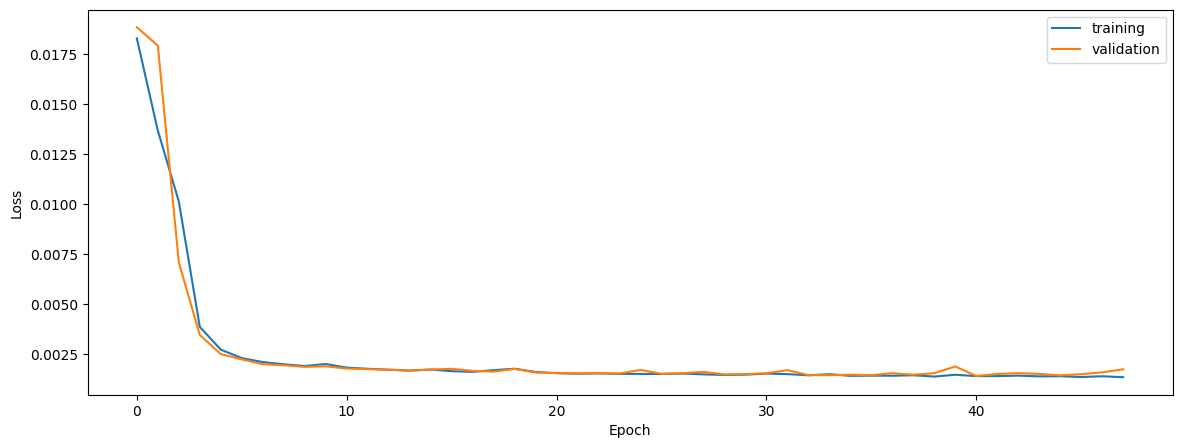

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9498881516879939
0.9629349744856144
0.9135448536783968


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.9498881516879939
0.9629349744856144
0.9135448536783968


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.9462542265936111
0.9587695060449816
0.9024403198790343


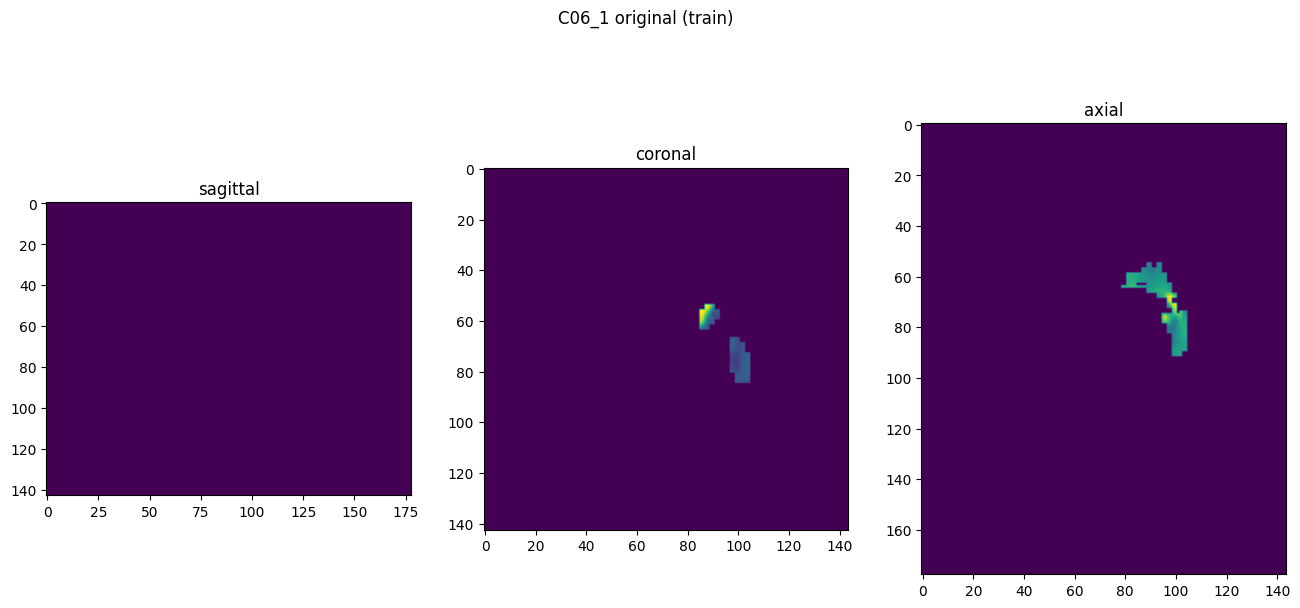

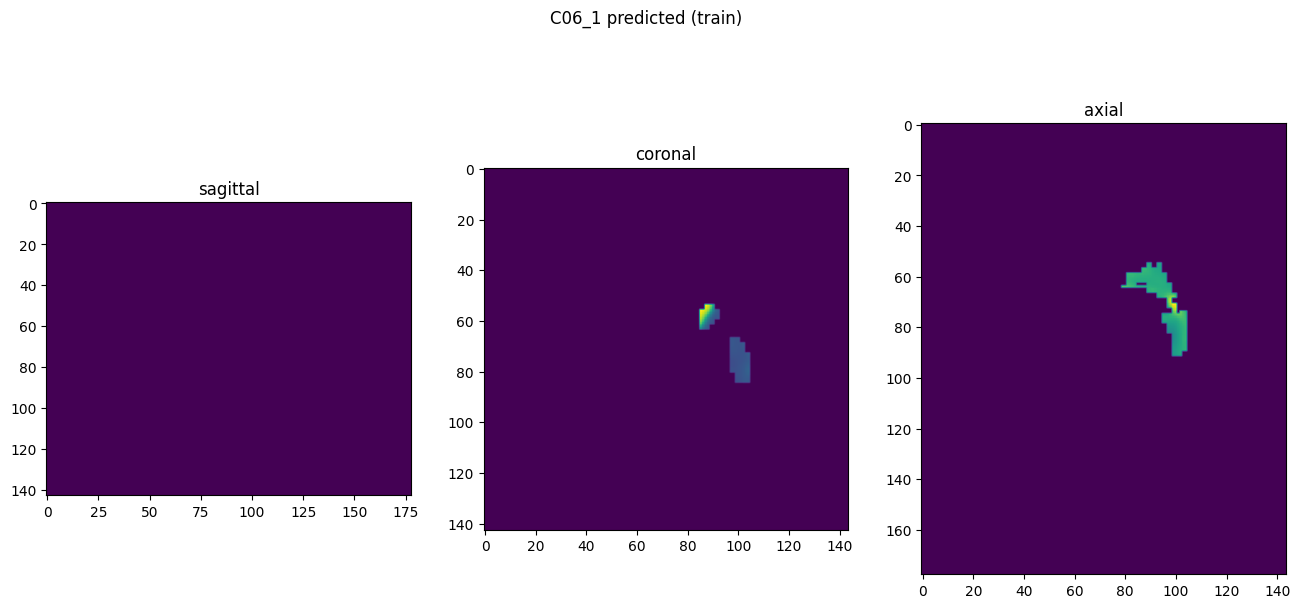

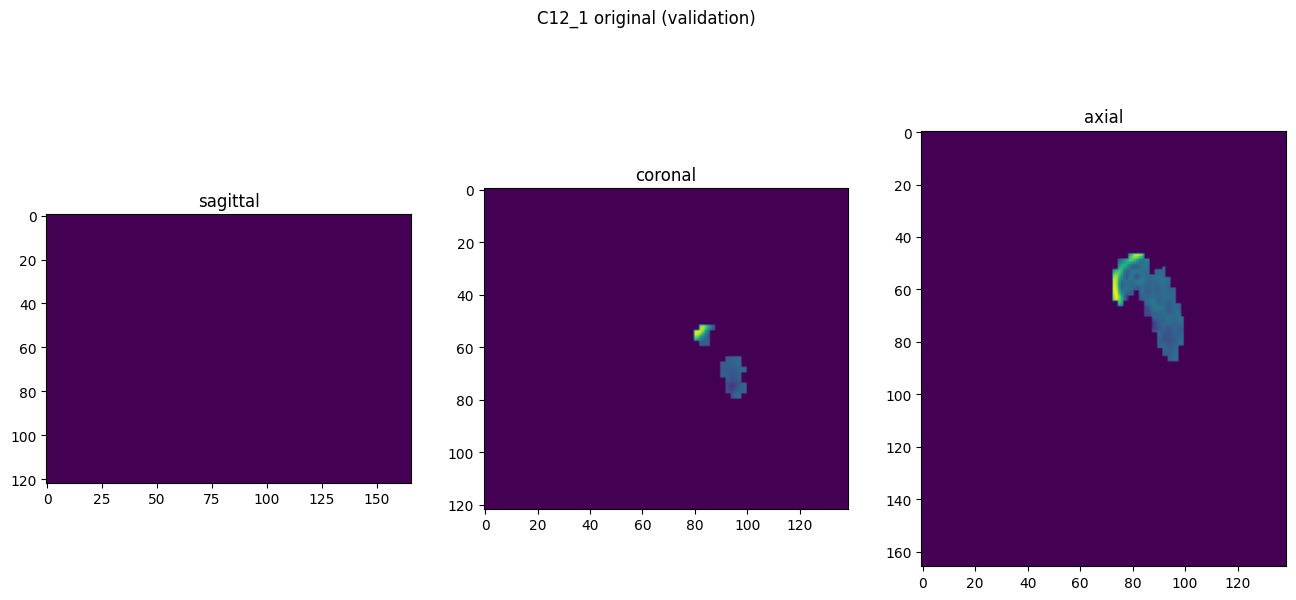

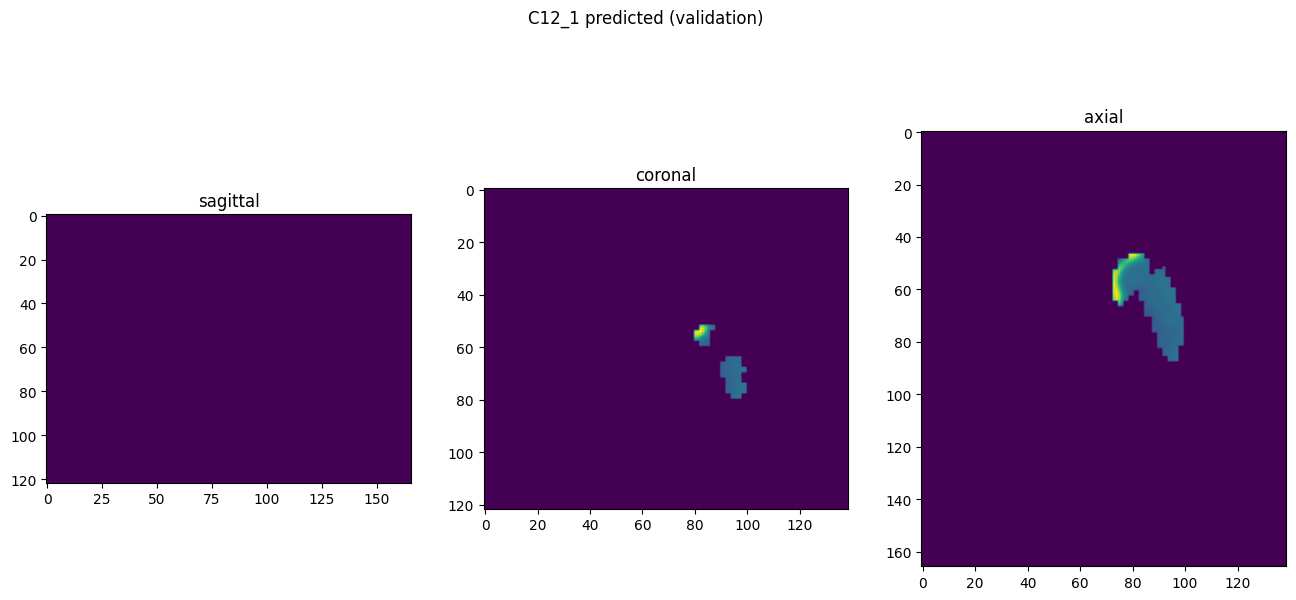

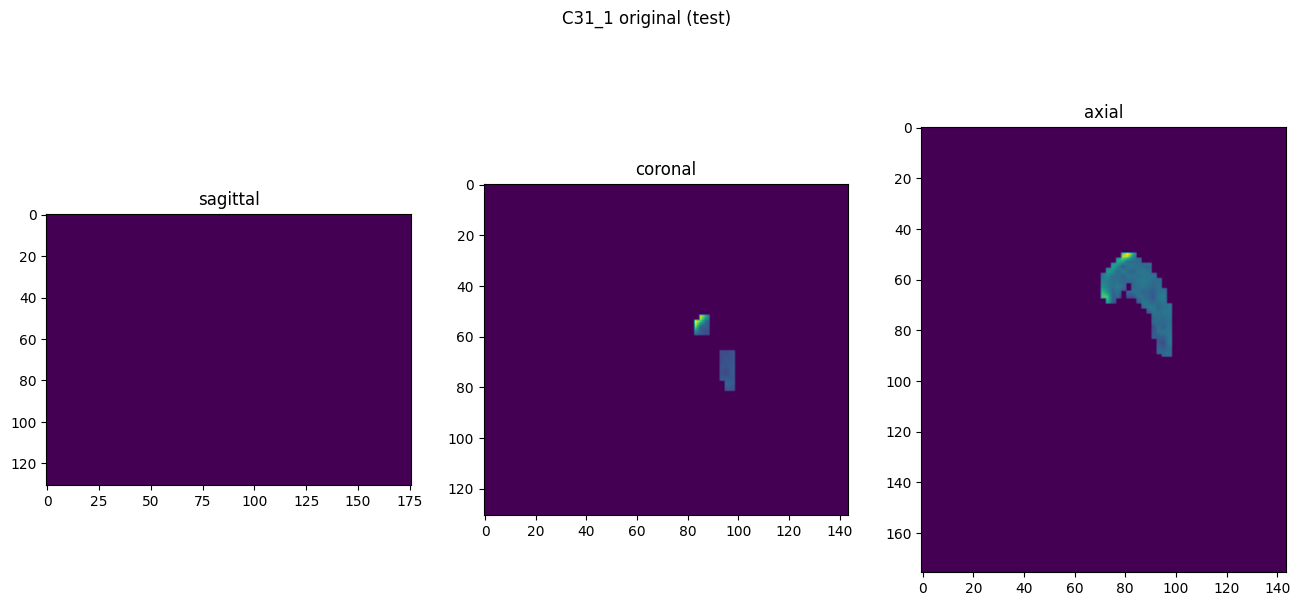

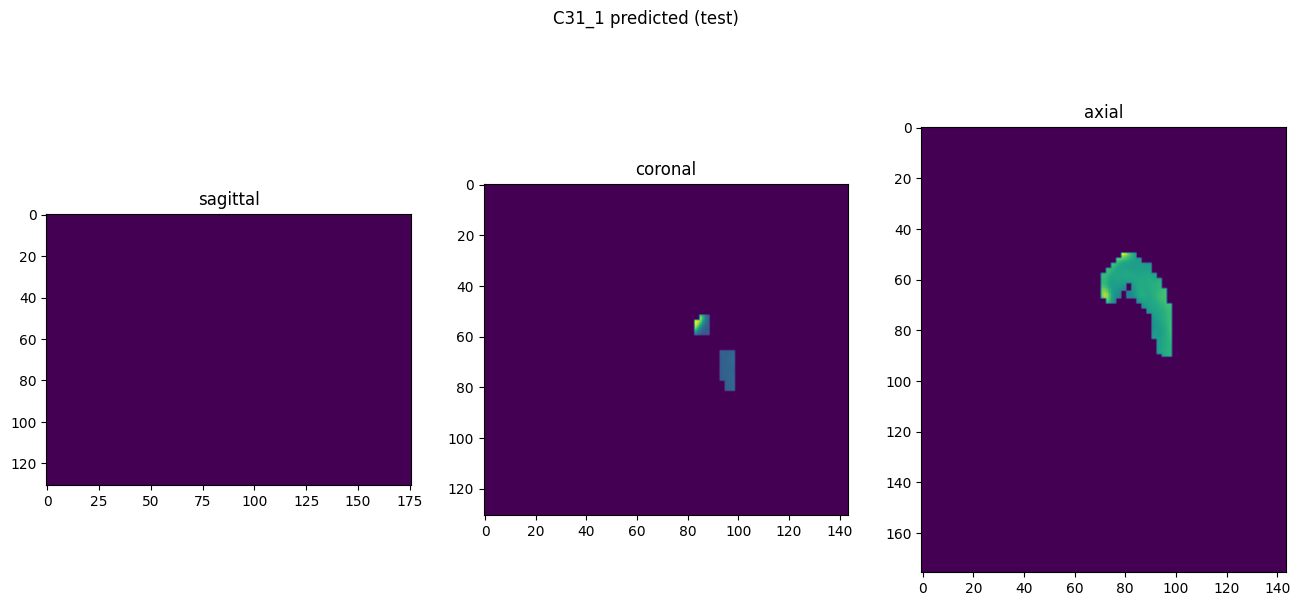

In [10]:
showResults(model, gen, threshold=None, background=False)